In [1]:
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
data = pd.read_csv('../data/HPG.csv')

# ARIMA

In [3]:
def process_data_arima(data):
    #định dạng lại cấu trúc thời gian
    data['time']=pd.to_datetime(data.time, format='mixed' ,dayfirst=False)

    # Lấy chuỗi thời gian giá 'close'
    data = np.log(data['close'])

    # Chia tập dữ liệu thành train/test (80% train, 20% test)
    train, test = train_test_split(data, test_size=0.2, shuffle=False)

    return train, test

In [62]:
train, test = process_data_arima(data)

In [3]:
import pickle

with open('../model/ARIMA-HPG.pkl', 'rb') as f:
    model = pickle.load(f)


In [64]:
forecast = model.predict(n_periods=len(test))

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# GRU

In [7]:
def process_data(data):
    # Đảm bảo residuals là numpy array 2D
    # if isinstance(residuals, pd.Series):
    #     residuals = residuals.values.reshape(-1, 1)
    # elif isinstance(residuals, np.ndarray) and residuals.ndim == 1:
    #     residuals = residuals.reshape(-1, 1)

    #định dạng lại cấu trúc thời gian
    data['time']=pd.to_datetime(data.time, format='mixed' ,dayfirst=False)

    #Lấy cột Close
    data=data[['close']]

    # Chia tập dữ liệu thành train/test (80% train, 20% test)
    x_train, x_test = train_test_split(data, test_size=0.2, shuffle=False)

    # Khởi tạo scaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Fit scaler trên tập huấn luyện và transform cả train lẫn test
    train_scaled = scaler.fit_transform(x_train)
    test_scaled = scaler.transform(x_test)

    #Tạo vòng lặp giá trị, lấy 60 ngày trong quá khứ để dự đoán ngày tiếp theo
    x_train = []
    y_train = []
    for i in range(60, len(train_scaled)):
        x_train.append(train_scaled[i-60:i, 0])
        y_train.append(train_scaled[i, 0])

    x_test = []
    y_test = []
    for i in range(60, len(test_scaled)):
        x_test.append(test_scaled[i-60:i, 0])
        y_test.append(test_scaled[i, 0])

    #Chuyển dạng list sang dạng mảng numpy
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)

    #Xếp dữ liệu thành mảng 1 chiều
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return x_train, y_train, x_test, y_test, scaler, test_scaled

In [65]:
x_train, y_train, x_test, y_test, scaler, test_scaled = process_data(data)

In [4]:
model_gru = load_model("../model/GRU-HPG.h5", compile=False)

In [ ]:
predict = model_gru.predict(x_test)
predict_test_price = scaler.inverse_transform(predict)
actual_test_price = scaler.inverse_transform(y_test.reshape(-1, 1))

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step


# ARIMA-GRU

In [ ]:
# Giữ dữ liệu ARIMA ở dạng chuẩn hóa (không exp)
arima_pred_scaled = forecast   
arima_true_scaled = test       

# GRU  dữ liệu scaled, chưa inverse
gru_pred_scaled = predict.reshape(-1)
gru_true_scaled = y_test.reshape(-1)

# Cắt độ dài cho khớp
min_len = min(len(arima_true_scaled), len(gru_true_scaled))
arima_pred_scaled = arima_pred_scaled[:min_len]
gru_pred_scaled = gru_pred_scaled[:min_len]
y_true_scaled = gru_true_scaled[:min_len]

In [12]:
# Tính alpha tối ưu
def compute_optimal_alpha(y_true, y_arima, y_gru):
    numerator = np.sum((y_arima - y_gru) * (y_true - y_gru))
    denominator = np.sum((y_arima - y_gru) ** 2)
    alpha = numerator / denominator if denominator != 0 else 0
    return max(0, min(1, alpha))

In [69]:
alpha = compute_optimal_alpha(y_true_scaled, arima_pred_scaled, gru_pred_scaled)
combined_pred_scaled = alpha * arima_pred_scaled + (1 - alpha) * gru_pred_scaled

In [70]:
alpha

0.005590415039755277

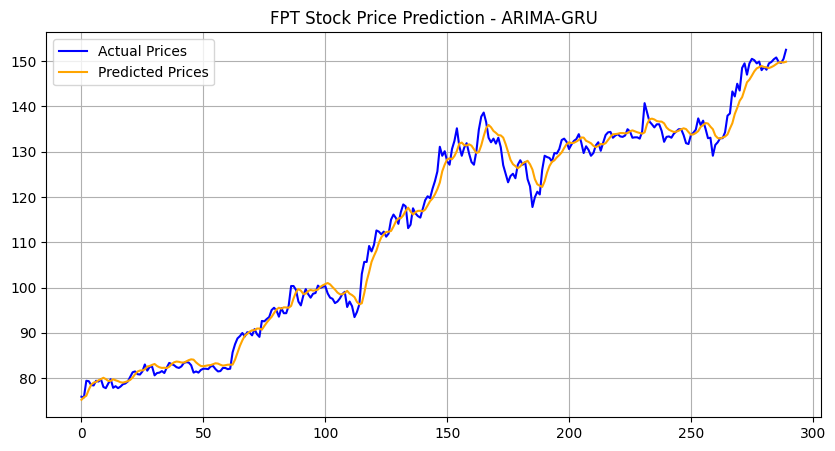

In [ ]:
#alpha: 0.007103687254298331
x_range = np.arange(len(y_true_scaled))  # từ 0 đến 290

plt.figure(figsize=(10,5))
plt.plot(x_range, scaler.inverse_transform(y_true_scaled.reshape(-1, 1)), label='Actual Prices', color='blue')
plt.plot(x_range, scaler.inverse_transform(combined_pred_scaled.values.reshape(-1, 1)), label='Predicted Prices', color='orange')
plt.title('FPT Stock Price Prediction - ARIMA-GRU')
plt.legend()
plt.grid(True)
plt.show()


In [39]:
#FPT
rmse = np.sqrt(mean_squared_error(y_true_scaled, combined_pred_scaled))
mae = mean_absolute_error(y_true_scaled, combined_pred_scaled)
r2 = r2_score(y_true_scaled, combined_pred_scaled)

print('RMSE:', rmse)
print('MAE:', mae)
print('R-squared:', r2)

RMSE: 0.04118077311810431
MAE: 0.03028189809856037
R-squared: 0.9891577489681597


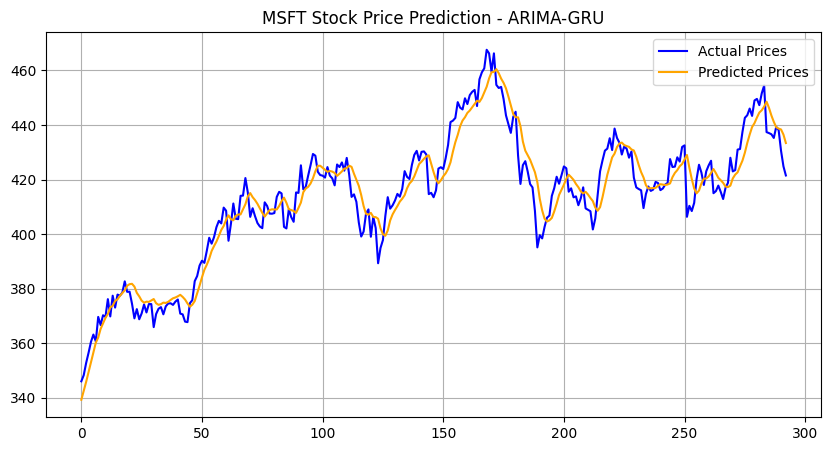

In [ ]:
#alpha: 0.005952824658786848
x_range = np.arange(len(y_true_scaled))  # từ 0 đến 290

plt.figure(figsize=(10,5))
plt.plot(x_range, scaler.inverse_transform(y_true_scaled.reshape(-1, 1)), label='Actual Prices', color='blue')
plt.plot(x_range, scaler.inverse_transform(combined_pred_scaled.values.reshape(-1, 1)), label='Predicted Prices', color='orange')
plt.title('MSFT Stock Price Prediction - ARIMA-GRU')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
#MSFT
rmse = np.sqrt(mean_squared_error(y_true_scaled, combined_pred_scaled))
mae = mean_absolute_error(y_true_scaled, combined_pred_scaled)
r2 = r2_score(y_true_scaled, combined_pred_scaled)

print('RMSE:', rmse)
print('MAE:', mae)
print('R-squared:', r2)

RMSE: 0.025281544645245135
MAE: 0.020560992507686917
R-squared: 0.9167646325504791


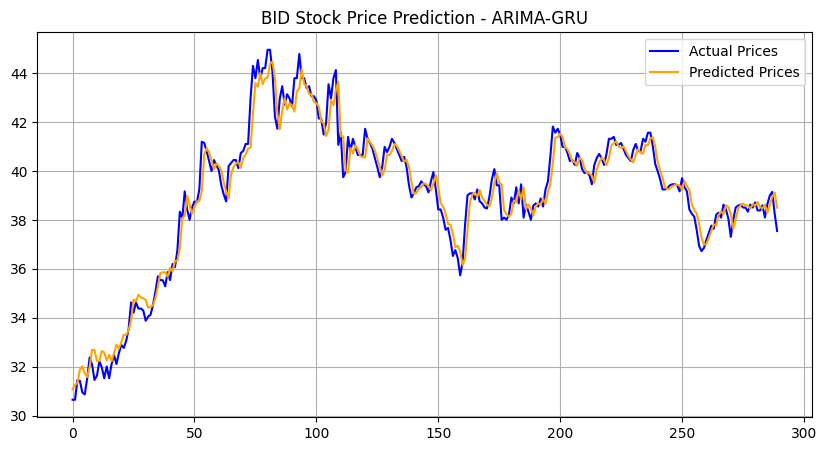

In [ ]:
#alpha: 0.013540734270431757
x_range = np.arange(len(y_true_scaled))  # từ 0 đến 290

plt.figure(figsize=(10,5))
plt.plot(x_range, scaler.inverse_transform(y_true_scaled.reshape(-1, 1)), label='Actual Prices', color='blue')
plt.plot(x_range, scaler.inverse_transform(combined_pred_scaled.values.reshape(-1, 1)), label='Predicted Prices', color='orange')
plt.title('BID Stock Price Prediction - ARIMA-GRU')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
#BID
rmse = np.sqrt(mean_squared_error(y_true_scaled, combined_pred_scaled))
mae = mean_absolute_error(y_true_scaled, combined_pred_scaled)
r2 = r2_score(y_true_scaled, combined_pred_scaled)

print('RMSE:', rmse)
print('MAE:', mae)
print('R-squared:', r2)

RMSE: 0.024836814149055014
MAE: 0.01812504089177821
R-squared: 0.961076216813719


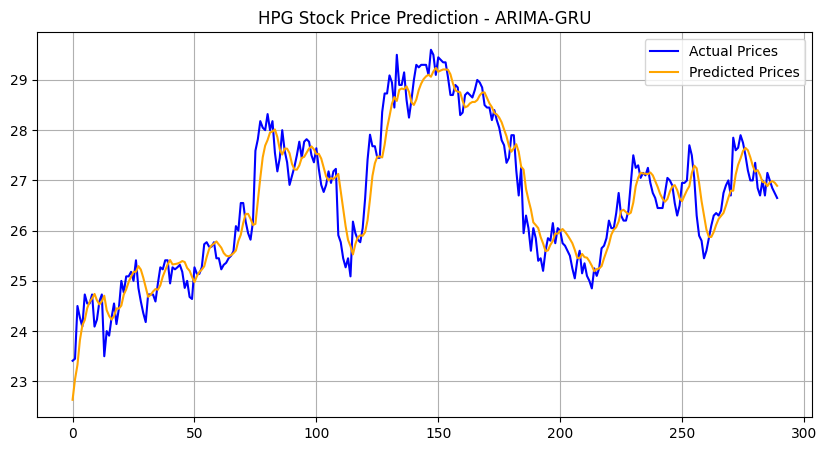

In [ ]:
#alpha: 0.005590415039755277
x_range = np.arange(len(y_true_scaled))  # từ 0 đến 290

plt.figure(figsize=(10,5))
plt.plot(x_range, scaler.inverse_transform(y_true_scaled.reshape(-1, 1)), label='Actual Prices', color='blue')
plt.plot(x_range, scaler.inverse_transform(combined_pred_scaled.values.reshape(-1, 1)), label='Predicted Prices', color='orange')
plt.title('HPG Stock Price Prediction - ARIMA-GRU')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
#HPG
rmse = np.sqrt(mean_squared_error(y_true_scaled, combined_pred_scaled))
mae = mean_absolute_error(y_true_scaled, combined_pred_scaled)
r2 = r2_score(y_true_scaled, combined_pred_scaled)

print('RMSE:', rmse)
print('MAE:', mae)
print('R-squared:', r2)

RMSE: 0.013100700960118382
MAE: 0.010000687208609707
R-squared: 0.9088953467265191


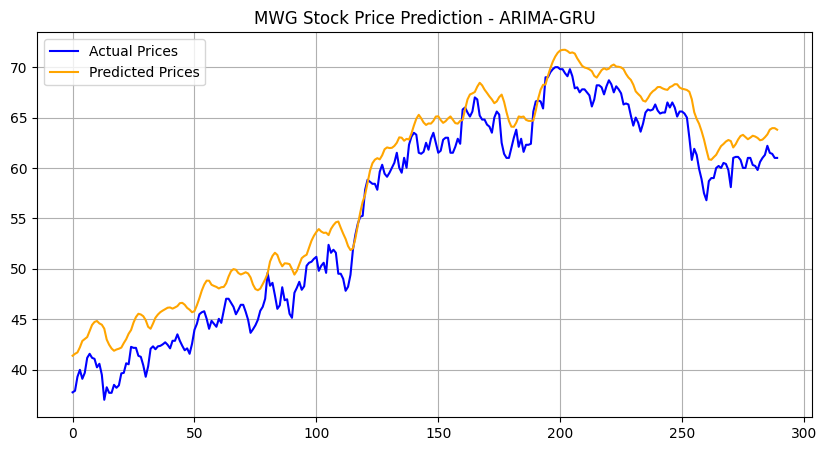

In [ ]:
#alpha: 0
x_range = np.arange(len(y_true_scaled))  # từ 0 đến 290

plt.figure(figsize=(10,5))
plt.plot(x_range, scaler.inverse_transform(y_true_scaled.reshape(-1, 1)), label='Actual Prices', color='blue')
plt.plot(x_range, scaler.inverse_transform(combined_pred_scaled.values.reshape(-1, 1)), label='Predicted Prices', color='orange')
plt.title('MWG Stock Price Prediction - ARIMA-GRU')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
#MWG
rmse = np.sqrt(mean_squared_error(y_true_scaled, combined_pred_scaled))
mae = mean_absolute_error(y_true_scaled, combined_pred_scaled)
r2 = r2_score(y_true_scaled, combined_pred_scaled)

print('RMSE:', rmse)
print('MAE:', mae)
print('R-squared:', r2)

RMSE: 0.049479514127419945
MAE: 0.04480660333322301
R-squared: 0.9129601252274655


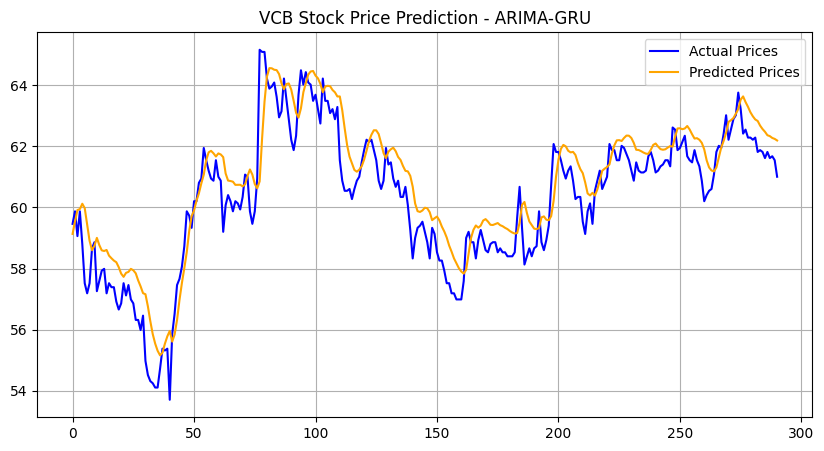

In [ ]:
#alpha: 0
x_range = np.arange(len(y_true_scaled))  # từ 0 đến 290

plt.figure(figsize=(10,5))
plt.plot(x_range, scaler.inverse_transform(y_true_scaled.reshape(-1, 1)), label='Actual Prices', color='blue')
plt.plot(x_range, scaler.inverse_transform(combined_pred_scaled.values.reshape(-1, 1)), label='Predicted Prices', color='orange')
plt.title('VCB Stock Price Prediction - ARIMA-GRU')
plt.legend()
plt.grid(True)
plt.show()

In [97]:
#VCB
rmse = np.sqrt(mean_squared_error(y_true_scaled, combined_pred_scaled))
mae = mean_absolute_error(y_true_scaled, combined_pred_scaled)
r2 = r2_score(y_true_scaled, combined_pred_scaled)

print('RMSE:', rmse)
print('MAE:', mae)
print('R-squared:', r2)

RMSE: 0.023305689874506572
MAE: 0.01928974665298852
R-squared: 0.8063904656838834


In [33]:
model_gru.save("model/ARIMA-GRU/ARIMA-GRU-FPT.h5")

# Dự đoán 10ngay

In [28]:
#model_arima là mô hình ARIMA đã fit trên log(price)
forecast_arima = model.predict(steps=10)

# đưa về giá trị gốc:
arima_pred = np.exp(forecast_arima) 


C:\Users\dinhq\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
n_days = 10
future_predict = []
last_input = x_test[-1].reshape(1, x_test.shape[1], x_test.shape[2])  # reshape (1, time_step, 1)

for _ in range(n_days):
    next_pred = model_gru.predict(last_input, verbose=0)
    future_predict.append(next_pred[0, 0])
    
    # Cập nhật đầu vào cho bước tiếp theo
    last_input = np.append(last_input[:, 1:, :], [[[next_pred[0, 0]]]], axis=1)

# Đưa về giá trị gốc
future_predict = np.array(future_predict).reshape(-1, 1)
future_prices = scaler.inverse_transform(future_predict)



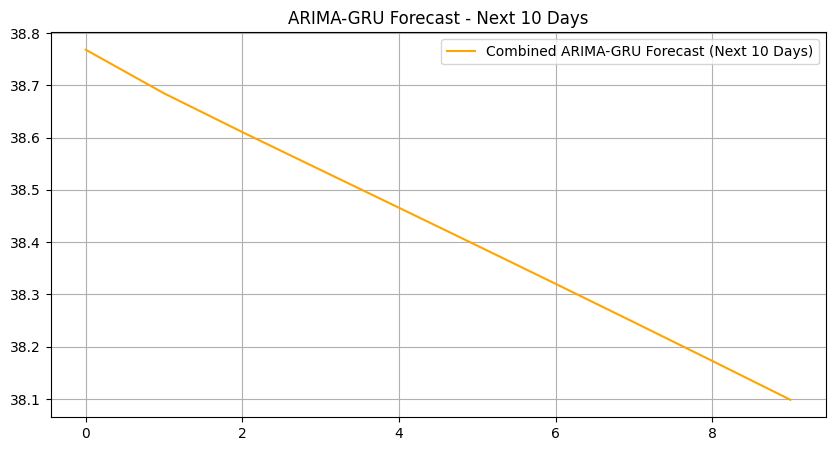

In [ ]:
gru_pred_10 = future_predict.flatten()  # đang ở scale
arima_pred_10 = forecast_arima[:10].values  #  scale 

# Tính alpha 
alpha = compute_optimal_alpha(y_true_scaled, arima_pred_scaled, gru_pred_scaled)

combined_pred_10 = alpha * gru_pred_10 + (1 - alpha) * arima_pred_10
combined_pred_10 = combined_pred_10.reshape(-1, 1)

# Đưa về giá trị gốc
combined_pred_10_inverse = scaler.inverse_transform(combined_pred_10)

# Vẽ
plt.figure(figsize=(10,5))
plt.plot(combined_pred_10_inverse, label='Combined ARIMA-GRU Forecast (Next 10 Days)', color='orange')
plt.grid(True)
plt.legend()
plt.title('ARIMA-GRU Forecast - Next 10 Days')
plt.show()


In [35]:
combined_pred_10_inverse

array([[38.76811238],
       [38.68473681],
       [38.61060254],
       [38.53817983],
       [38.46592081],
       [38.39340333],
       [38.32048955],
       [38.24707322],
       [38.17310838],
       [38.09857206]])